#####  The TensorFlow Authors.

# Neural machine translation with attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/nmt_with_attention.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook trains a sequence to sequence (seq2seq) model for Spanish to English translation. This is an advanced example that assumes some knowledge of sequence to sequence models.

After training the model in this notebook, you will be able to input a Spanish sentence, such as *"¿todavia estan en casa?"*, and return the English translation: *"are you still at home?"*

The translation quality is reasonable for a toy example, but the generated attention plot is perhaps more interesting. This shows which parts of the input sentence has the model's attention while translating:

<img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot">

Note: This example takes approximately 10 minutes to run on a single P100 GPU.

In [1]:
# Import the TensorFlow library for deep learning.
import tensorflow as tf

# Import necessary modules for data visualization and preprocessing.
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

# Import modules for text preprocessing and manipulation.
import unicodedata
import re
import numpy as np
import os
import io
import time


## Download and prepare the dataset

We'll use a language dataset provided by http://www.manythings.org/anki/. This dataset contains language translation pairs in the format:

```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

There are a variety of languages available, but we'll use the English-Spanish dataset. For convenience, we've hosted a copy of this dataset on Google Cloud, but you can also download your own copy. After downloading the dataset, here are the steps we'll take to prepare the data:

1. Add a *start* and *end* token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [2]:
arabic_data = "http://www.manythings.org/anki/ara-eng.zip"

In [3]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2638744/2638744 [==============================] - 0s 0us/step


In [4]:
# Converts a Unicode string to ASCII by normalizing and removing diacritics.
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')


Function Explanation:

* unicode_to_ascii is a function that takes a Unicode string s as input.

* It uses the unicodedata.normalize function to normalize the Unicode string, which decomposes characters with diacritics into their base characters (e.g., converting accented characters to their non-accented counterparts).

* The if unicodedata.category(c) != 'Mn' condition filters out characters with the category 'Mn' (Mark, Nonspacing) which includes diacritics.

* The function returns the Unicode string converted to ASCII without diacritics.

In [6]:
# Define the Unicode string with diacritics
unicode_string = "Thérè àrè sômè àccèntéd characters hère."

# Call the unicode_to_ascii function to convert it to ASCII
ascii_string = unicode_to_ascii(unicode_string)

# Print the result
print(ascii_string)


There are some accented characters here.


In [15]:
# Add spaces around punctuation to separate them from words.
# For example, "he is a boy." becomes "he is a boy ."
w="he is a boy."
#r"([?.!,¿])": This is the pattern to search for a common punctuation marks.
#\1 is a backreference to the captured group in the pattern. In this case, it's the punctuation mark that was matched. So, it effectively replaces the matched punctuation mark with itself.
w=re.sub(r"([?.!,¿])", r" \1 ", w)
# replaces multiple spaces with a single space character.
re.sub(r'[" "]+', " ", w)

'he is a boy . '

In [16]:
def preprocess_sentence(w):
    # Call unicode_to_ascii func then Convert the sentence to lowercase and remove leading/trailing whitespace.
    w = unicode_to_ascii(w.lower().strip())

    # Add spaces around punctuation to separate them from words.
    # For example, "he is a boy." becomes "he is a boy ."
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # Replace characters that are not letters or common punctuation marks with a space.
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    # Remove leading and trailing spaces.
    w = w.strip()

    # Add special tokens '<start>' and '<end>' to mark the beginning and end of a sentence.
    w = '<start> ' + w + ' <end>'
    return w


In [17]:
# Define an English sentence with punctuation.
en_sentence = u"May I borrow this book?"

# Define a Spanish sentence with punctuation and a special character ("¿").
sp_sentence = u"¿Puedo tomar prestado este libro?"

# Preprocess and print the English sentence.
print(preprocess_sentence(en_sentence))

# Preprocess the Spanish sentence and encode it in UTF-8 for printing.
print(preprocess_sentence(sp_sentence).encode('utf-8'))


<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [26]:
# This function creates a dataset by reading data from a file and preprocessing it.
# The preprocessing steps include removing accents, cleaning the sentences, and formatting the data as word pairs.
# The function returns the word pairs in the format [ENGLISH, SPANISH].

def create_dataset(path, num_examples):
    # Read and split the lines from the file, assuming UTF-8 encoding.
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    # Preprocess each line and create word pairs.
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')] for l in lines[:num_examples]]

    # Return the word pairs as separate lists (unzipped).
    return zip(*word_pairs)


Example of a word_pairs list :

    word_pairs = [
        ['<start> i like pizza . <end>', '<start> me gusta la pizza . <end>'],
        ['<start> she speaks french . <end>', '<start> ella habla francés . <end>'],
        ['<start> cats are cute . <end>', '<start> los gatos son lindos . <end>'],
        # ... (more pairs)
    ]

In [27]:
# Create a dataset by calling the create_dataset function, providing the path to a file and requesting all available examples.
en, sp = create_dataset(path_to_file, None)

# Print the last example (English) in the dataset.
print(en[-1])

# Print the last example (Spanish) in the dataset.
print(sp[-1])


<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [28]:
# This function tokenizes a language by converting text sentences into numerical tensors.
# It also creates a tokenizer to map words to numeric indices.

def tokenize(lang):
    # Create a tokenizer for the specified language.
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')

    # Fit the tokenizer on the language data to build the word-to-index mapping.
    lang_tokenizer.fit_on_texts(lang)

    # Convert text sentences to sequences of integers using the tokenizer.
    tensor = lang_tokenizer.texts_to_sequences(lang)

    # Pad the sequences to have the same length (padding at the end).
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

    # Return the padded tensor and the language tokenizer.
    return tensor, lang_tokenizer


In [29]:
# This function loads and preprocesses a dataset from a file, creating input-output pairs.
# It tokenizes both the input and target languages and returns the processed data and tokenizers.

def load_dataset(path, num_examples=None):
    # Create cleaned input and target pairs using create_dataset function.
    targ_lang, inp_lang = create_dataset(path, num_examples)

    # Tokenize the input language and get the tokenizer.
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)

    # Tokenize the target language and get the tokenizer.
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    # Return the tokenized input and target tensors, and their respective tokenizers.
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer


### Limit the size of the dataset to experiment faster (optional)

Training on the complete dataset of >100,000 sentences will take a long time. To train faster, we can limit the size of the dataset to 30,000 sentences (of course, translation quality degrades with less data):

In [36]:
# Experiment with the size of the dataset by setting the number of examples.
num_examples = 30000

# Load the dataset with the specified number of examples.
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate and print the maximum lengths of target and input tensors.
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

# Print the maximum length of the target tensors.
print(max_length_targ)

# Print the maximum length of the input tensors.
print(max_length_inp)


11
16


In [37]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [38]:
# This function converts a tensor of numeric indices back into human-readable text using a language's index-to-word mapping.

def convert(lang, tensor):
    # Iterate through each element in the tensor.
    for t in tensor:
        # Check if the element is not equal to 0 (0 typically represents padding).
        if t != 0:
            # Print the numeric index and its corresponding word from the language's index-to-word mapping.
            print ("%d ----> %s" % (t, lang.index_word[t]))


In [39]:
# Print the index-to-word mapping for the input language.
print("Input Language; index to word mapping")
# Convert and display the first sequence in the input tensor.
convert(inp_lang, input_tensor_train[0])

# Print an empty line for clarity.
print()

# Print the index-to-word mapping for the target language.
print("Target Language; index to word mapping")
# Convert and display the first sequence in the target tensor.
convert(targ_lang, target_tensor_train[0])


Input Language; index to word mapping
1 ----> <start>
4 ----> tom
143 ----> podria
1507 ----> caer
255 ----> enfermo
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
5 ----> tom
292 ----> might
64 ----> get
232 ----> sick
3 ----> .
2 ----> <end>


### Create a tf.data dataset

In [40]:
# Define the buffer size for shuffling the dataset.
BUFFER_SIZE = len(input_tensor_train)

# Define the batch size for training.
BATCH_SIZE = 64

# Calculate the number of steps per epoch for training.
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE

# Define the embedding dimension for the model.
embedding_dim = 256

# Define the number of units (or neurons) in the model.
units = 1024

# Calculate the vocabulary size for the input language, including an extra token for padding.
vocab_inp_size = len(inp_lang.word_index) + 1

# Calculate the vocabulary size for the target language, including an extra token for padding.
vocab_tar_size = len(targ_lang.word_index) + 1

# Create a TensorFlow dataset from the input and target tensors, and shuffle the data.
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)

# Create batches of data with the specified batch size, dropping any remaining examples if the batch size doesn't evenly divide the dataset.
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)


In [41]:
# Get the next batch of input and target data from the dataset.
example_input_batch, example_target_batch = next(iter(dataset))

# Print the shapes of the input and target batches.
print("Shape of the input batch:", example_input_batch.shape)
print("Shape of the target batch:", example_target_batch.shape)


Shape of the input batch: (64, 16)
Shape of the target batch: (64, 11)


## Write the encoder and decoder model

Implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. The below picture and formulas are an example of attention mechanism from [Luong's paper](https://arxiv.org/abs/1508.04025v5).

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*.

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

This tutorial uses [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) for the encoder. Let's decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU

The shapes of all the vectors at each step have been specified in the comments in the code:

In [42]:
# Define the Encoder class for the sequence-to-sequence model.
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        # Store the batch size and encoder units for later use.
        self.batch_sz = batch_sz
        self.enc_units = enc_units

        # Create an embedding layer for word embeddings.
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        # Create a GRU (Gated Recurrent Unit) layer for encoding sequences.
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    # Define the forward pass of the Encoder.
    def call(self, x, hidden):
        # Pass the input sequence through the embedding layer.
        x = self.embedding(x)

        # Pass the embedded sequence through the GRU layer, initializing with the provided hidden state.
        output, state = self.gru(x, initial_state=hidden)

        # Return the output sequence and the final state of the GRU.
        return output, state

    # Initialize the hidden state to zeros.
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))


In [43]:
# Create an instance of the Encoder class with specified parameters.
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# Initialize a sample hidden state for the encoder.
sample_hidden = encoder.initialize_hidden_state()

# Pass a sample input batch through the encoder to get output and updated hidden state.
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

# Print the shapes of the encoder output and hidden state for illustration.
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))


Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [45]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [46]:
# Create an instance of the BahdanauAttention layer with 10 units.
attention_layer = BahdanauAttention(10)

# Calculate attention results and weights using a sample hidden state and output.
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

# Print the shapes of the attention result and weights for illustration.
print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))


Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [47]:
# Define the Decoder class for the sequence-to-sequence model.
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        # Store the batch size and decoder units for later use.
        self.batch_sz = batch_sz
        self.dec_units = dec_units

        # Create an embedding layer for word embeddings.
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        # Create a GRU (Gated Recurrent Unit) layer for decoding sequences.
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        # Create a fully connected layer for generating output tokens.
        self.fc = tf.keras.layers.Dense(vocab_size)

        # Create an attention mechanism using BahdanauAttention.
        self.attention = BahdanauAttention(self.dec_units)

    # Define the forward pass of the Decoder.
    def call(self, x, hidden, enc_output):
        # Calculate context vector and attention weights using the attention mechanism.
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # Pass the input token through the embedding layer.
        x = self.embedding(x)

        # Concatenate the context vector and embedded token.
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # Pass the concatenated vector through the GRU layer.
        output, state = self.gru(x)

        # Reshape the output for further processing.
        output = tf.reshape(output, (-1, output.shape[2]))

        # Generate the output token probabilities using the fully connected layer.
        x = self.fc(output)

        return x, state, attention_weights


In [48]:
# Create an instance of the Decoder class with specified parameters.
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

# Generate a sample decoder output using random input.
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

# Print the shape of the decoder output for illustration.
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))


Decoder output shape: (batch_size, vocab size) (64, 4935)


## Define the optimizer and the loss function

In [49]:
# Create a boolean list 'x' containing True and False values.
x = [True, True, False]

# Use TensorFlow's tf.math.logical_not function to compute the logical NOT operation on each element of 'x'.
# It negates True to False and False to True.
result = tf.math.logical_not(x)


In [50]:
# Create an instance of the Adam optimizer from TensorFlow for model optimization.
optimizer = tf.keras.optimizers.Adam()

# Create a loss object using Sparse Categorical Cross-Entropy loss function.
# Set 'from_logits=True' to indicate that the model produces logits (raw scores) as output.
# 'reduction' specifies how to compute the final loss, and 'none' means no reduction.
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# Define a custom loss function for the sequence-to-sequence model.
def loss_function(real, pred):
    # Create a mask to identify non-padding elements in the target sequences.
    mask = tf.math.logical_not(tf.math.equal(real, 0))

    # Calculate the initial loss using the loss_object.
    loss_ = loss_object(real, pred)

    # Convert the mask to the same data type as the loss for element-wise multiplication.
    mask = tf.cast(mask, dtype=loss_.dtype)

    # Apply the mask to the loss to ignore padding elements in the loss calculation.
    loss_ *= mask

    # Calculate the mean of the masked loss to get the final loss value.
    return tf.reduce_mean(loss_)


## Checkpoints (Object-based saving)

In [51]:
# Specify the directory where training checkpoints will be saved.
checkpoint_dir = './training_checkpoints'

# Create a checkpoint prefix to be used for naming checkpoint files.
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Create a TensorFlow Checkpoint object to save and restore model-related variables.
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)


## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [52]:
# Define a TensorFlow function for training a single step (one batch) of the model.
@tf.function
def train_step(inp, targ, enc_hidden):
    # Initialize the loss.
    loss = 0

    # Use GradientTape to record operations for automatic differentiation.
    with tf.GradientTape() as tape:
        # Encode the input sequence.
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        # Initialize the decoder's hidden state with the encoder's final hidden state.
        dec_hidden = enc_hidden

        # Initialize the decoder's input with the '<start>' token.
        dec_input = tf.expand_dims(
            [targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing: feeding the target as the next input.
        for t in range(1, targ.shape[1]):
            # Pass the encoder's output to the decoder.
            predictions, dec_hidden, _ = decoder(
                dec_input, dec_hidden, enc_output)

            # Compute the loss using the loss function.
            loss += loss_function(targ[:, t], predictions)

            # Use teacher forcing: set the next input to be the true target token.
            dec_input = tf.expand_dims(targ[:, t], 1)

    # Calculate the batch loss as the average loss over the sequence length.
    batch_loss = (loss / int(targ.shape[1]))

    # Get all the trainable variables of the encoder and decoder.
    variables = encoder.trainable_variables + decoder.trainable_variables

    # Compute gradients of the loss with respect to the variables.
    gradients = tape.gradient(loss, variables)

    # Apply gradients to update the model's trainable variables.
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss


Function Explanation:

@tf.function: This is a decorator for the train_step function, which converts it into a TensorFlow graph for improved performance during training. It optimizes the function by tracing its operations and compiling them into a graph, which can be executed more efficiently.

with tf.GradientTape() as tape:: This context manager is used to record operations inside it for automatic differentiation. It allows you to compute gradients with respect to the trainable variables.

enc_output, enc_hidden = encoder(inp, enc_hidden): This line encodes the input sequence (inp) using the encoder, producing encoder outputs (enc_output) and the final encoder hidden state (enc_hidden).

dec_hidden = enc_hidden: The decoder's initial hidden state is set to the final encoder hidden state, initializing the decoder's state based on the input.

dec_input = tf.expand_dims(...): The decoder's initial input is set to the '<start>' token. This line creates a tensor with the '<start>' token repeated for each batch in the input batch.

Teacher Forcing Loop: The following loop implements teacher forcing, where the true target tokens are used as inputs to the decoder for training:

for t in range(1, targ.shape[1]):: Iterate over the time steps of the target sequence.
predictions, dec_hidden, _ = decoder(...): Pass the decoder input, decoder hidden state, and encoder output to the decoder. This generates predictions for the next target tokens and updates the decoder's hidden state.
loss += loss_function(...): Compute the loss for the predicted tokens compared to the true target tokens.
batch_loss = (loss / int(targ.shape[1])): Calculate the batch loss as the average loss over the sequence length. This ensures that the loss is normalized by the number of time steps in the sequence.

variables = encoder.trainable_variables + decoder.trainable_variables: Get all the trainable variables of both the encoder and the decoder.

gradients = tape.gradient(loss, variables): Compute gradients of the loss with respect to the trainable variables using the recorded operations within the tf.GradientTape.

optimizer.apply_gradients(zip(gradients, variables)): Apply the computed gradients to update the model's trainable variables using the optimizer (Adam in this case).

Finally, the function returns the batch_loss, representing the average loss for the current batch. This loss will be used to monitor the training progress and adjust model parameters during training.

In [53]:
# Define the number of training epochs.
EPOCHS = 10

# Loop through training for the specified number of epochs.
for epoch in range(EPOCHS):
    # Record the start time of the current epoch.
    start = time.time()

    # Initialize the hidden state of the encoder for the current epoch.
    enc_hidden = encoder.initialize_hidden_state()

    # Initialize the total loss for the epoch.
    total_loss = 0

    # Iterate over the batches in the dataset.
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        # Calculate the loss for the current batch and update the total loss.
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        # Print batch-level training progress every 100 batches.
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))

    # Save a checkpoint of the model every 2 epochs.
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    # Print the average loss for the epoch and the time taken for the epoch.
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 4.4936
Epoch 1 Batch 100 Loss 2.1918
Epoch 1 Batch 200 Loss 1.7804
Epoch 1 Batch 300 Loss 1.7993
Epoch 1 Loss 2.0158
Time taken for 1 epoch 54.100929975509644 sec

Epoch 2 Batch 0 Loss 1.5686
Epoch 2 Batch 100 Loss 1.4374
Epoch 2 Batch 200 Loss 1.2984
Epoch 2 Batch 300 Loss 1.1682
Epoch 2 Loss 1.3556
Time taken for 1 epoch 27.880091190338135 sec

Epoch 3 Batch 0 Loss 1.0614
Epoch 3 Batch 100 Loss 1.0219
Epoch 3 Batch 200 Loss 0.9446
Epoch 3 Batch 300 Loss 0.7682
Epoch 3 Loss 0.9243
Time taken for 1 epoch 27.233625650405884 sec

Epoch 4 Batch 0 Loss 0.5665
Epoch 4 Batch 100 Loss 0.6036
Epoch 4 Batch 200 Loss 0.6234
Epoch 4 Batch 300 Loss 0.6089
Epoch 4 Loss 0.6090
Time taken for 1 epoch 27.88387703895569 sec

Epoch 5 Batch 0 Loss 0.3832
Epoch 5 Batch 100 Loss 0.3796
Epoch 5 Batch 200 Loss 0.4343
Epoch 5 Batch 300 Loss 0.3986
Epoch 5 Loss 0.4088
Time taken for 1 epoch 27.532286643981934 sec

Epoch 6 Batch 0 Loss 0.2692
Epoch 6 Batch 100 Loss 0.2588
Epoch 6 Batch 200 

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [54]:
# Define a function for evaluating a given sentence using the trained model.
def evaluate(sentence):
    # Initialize an empty attention plot for visualization.
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    # Preprocess the input sentence.
    sentence = preprocess_sentence(sentence)

    # Convert the preprocessed sentence into a sequence of word indices.
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]

    # Pad the input sequence to match the maximum input length.
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    # Initialize an empty result.
    result = ''

    # Initialize the hidden state for the encoder.
    hidden = [tf.zeros((1, units))]

    # Encode the input sentence using the encoder.
    enc_out, enc_hidden = encoder(inputs, hidden)

    # Initialize the decoder's hidden state with the encoder's final hidden state.
    dec_hidden = enc_hidden

    # Initialize the decoder's input with the '<start>' token.
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    # Loop over the maximum target sequence length.
    for t in range(max_length_targ):
        # Generate predictions, decoder hidden state, and attention weights for the current step.
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # Store the attention weights for visualization.
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        # Get the predicted token's index with the highest probability.
        predicted_id = tf.argmax(predictions[0]).numpy()

        # Add the predicted token to the result.
        result += targ_lang.index_word[predicted_id] + ' '

        # If the predicted token is '<end>', return the result and attention plot.
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # Set the predicted ID as the next input to the decoder.
        dec_input = tf.expand_dims([predicted_id], 0)

    # If the maximum target sequence length is reached, return the result and attention plot.
    return result, sentence, attention_plot


In [55]:
# Define a function for plotting the attention weights.
def plot_attention(attention, sentence, predicted_sentence):
    # Create a new figure for the attention plot with a specified size.
    fig = plt.figure(figsize=(10, 10))

    # Add a subplot to the figure.
    ax = fig.add_subplot(1, 1, 1)

    # Display the attention matrix as an image with the 'viridis' colormap.
    ax.matshow(attention, cmap='viridis')

    # Define the font properties for the tick labels.
    fontdict = {'fontsize': 14}

    # Set the tick labels for the x-axis (input sentence).
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)

    # Set the tick labels for the y-axis (predicted sentence).
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    # Set major tick locations for both axes.
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Display the plot.
    plt.show()


In [57]:
# Define a function for translating a sentence using the trained model.
def translate(sentence):
    # Call the evaluate function to perform translation and obtain attention weights.
    result, sentence, attention_plot = evaluate(sentence)

    # Print the input sentence and the predicted translation.
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    # Truncate the attention plot to match the lengths of the input and output sentences.
    attention_plot = attention_plot[:len(
        result.split(' ')), :len(sentence.split(' '))]

    # Call the plot_attention function to visualize the attention weights.
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))


## Restore the latest checkpoint and test

In [58]:
# Restore the latest checkpoint from the checkpoint directory.
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> amarla <end>
Predicted translation: give me to be rich here to be rich here to 


<ipython-input-55-20db3a42042f>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-55-20db3a42042f>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


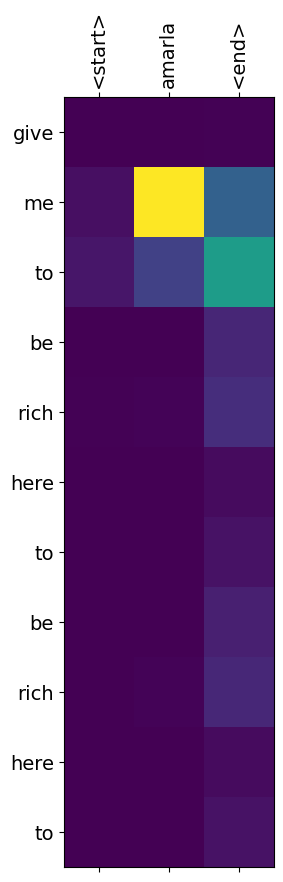

In [59]:
translate(u'amarla')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


<ipython-input-55-20db3a42042f>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-55-20db3a42042f>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


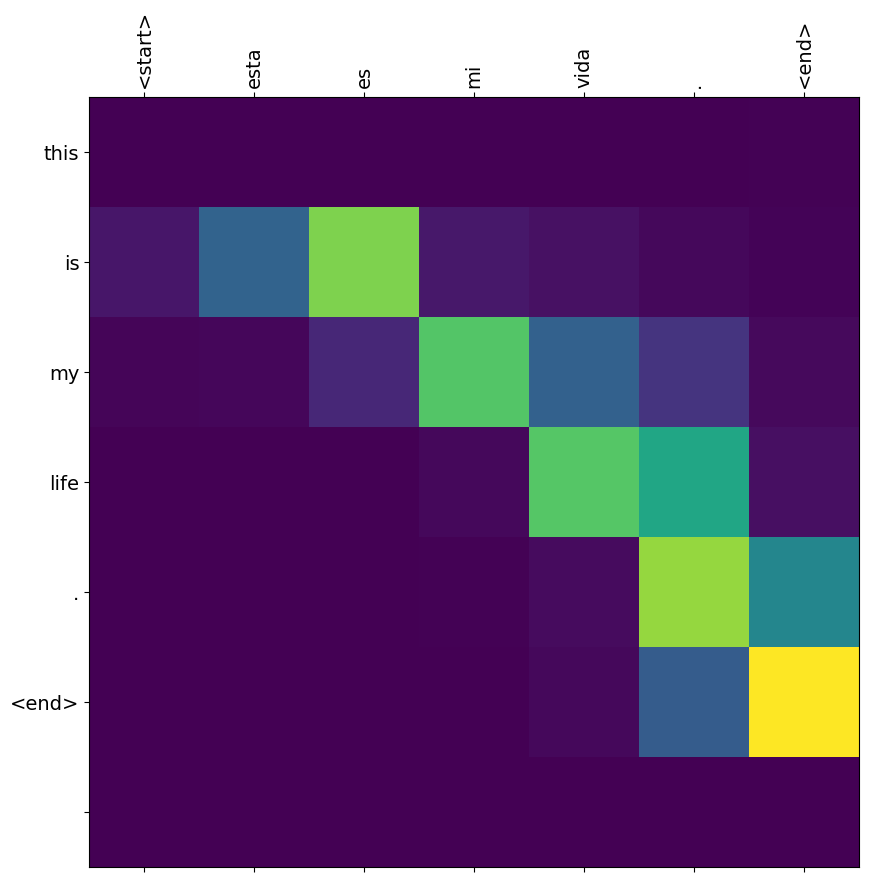

In [60]:
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


<ipython-input-55-20db3a42042f>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-55-20db3a42042f>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


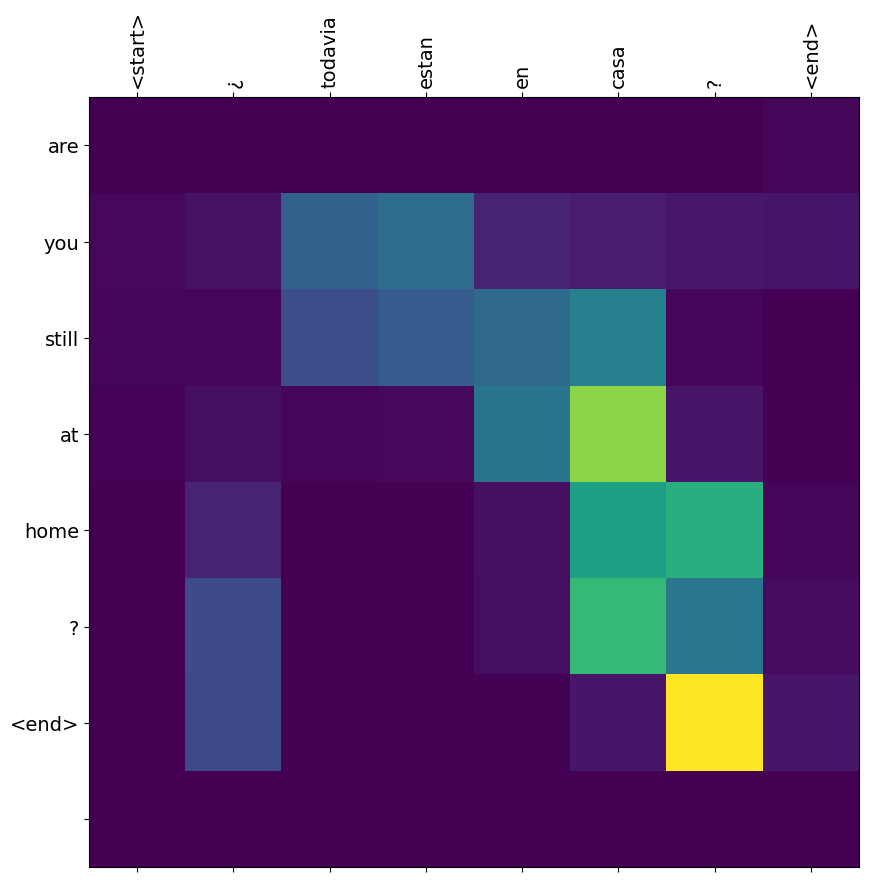

In [61]:
translate(u'¿todavia estan en casa?')

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to figure it out . <end> 


<ipython-input-55-20db3a42042f>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-55-20db3a42042f>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


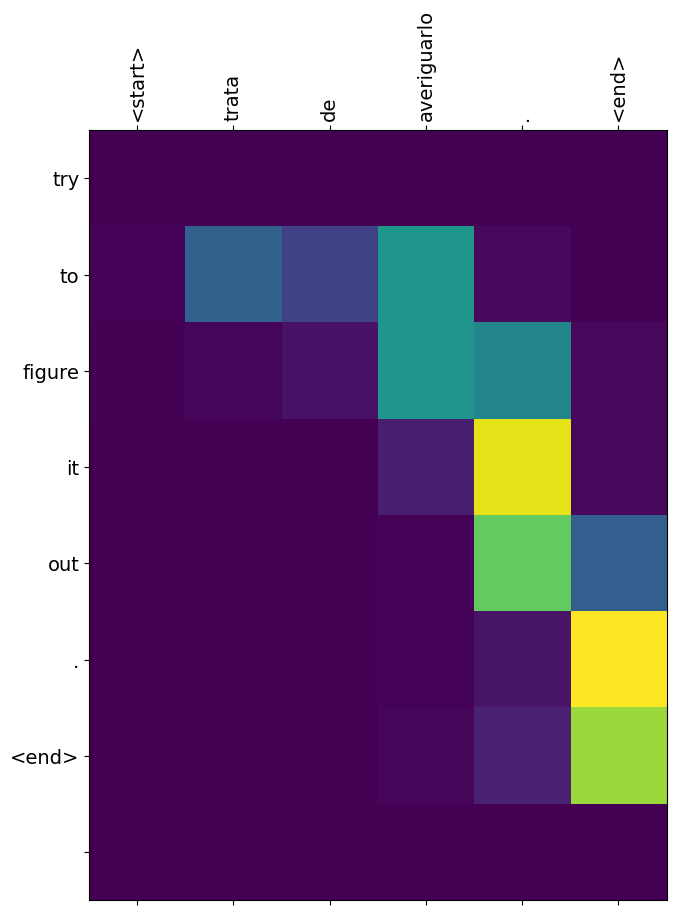

In [62]:
# wrong translation
translate(u'trata de averiguarlo.')

## Next steps

* [Download a different dataset](http://www.manythings.org/anki/) to experiment with translations, for example, English to German, or English to French.
* Experiment with training on a larger dataset, or using more epochs
